In [5]:
!pip install scikit-learn scipy numpy plotly pandas nbformat

  Using cached nbformat-5.9.2-py3-none-any.whl.metadata (3.4 kB)
  Using cached fastjsonschema-2.18.1-py3-none-any.whl.metadata (2.0 kB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached jsonschema_specifications-2023.7.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached referencing-0.30.2-py3-none-any.whl.metadata (2.6 kB)
Using cached nbformat-5.9.2-py3-none-any.whl (77 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 696.9 kB/s eta 0:00:000:00:01
Using cached fastjsonschema-2.18.1-py3-none-any.whl (23 kB)
Using cached jsonschema_specifications-2023.7.1-py3-none-any.whl (17 kB)
Using cached referencing-0.30.2-py3-none-any.whl (25 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 11.2 MB/s eta 0:00:00


In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate some data
X, y = make_classification(n_samples=1000, n_features=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simulate new data with some drift
new_data, _ = make_classification(n_samples=1000, n_features=20, shift=0.5)


In [4]:
X_train.shape, new_data.shape

((800, 20), (1000, 20))

In [5]:
import plotly.express as px

fig = px.histogram(X_train, nbins=20)
fig.show()

In [3]:
import plotly.express as px

fig = px.histogram(new_data, nbins=20)
fig.show()


The Kolmogorov-Smirnov (K-S) test is used to compare the cumulative distribution functions (CDFs) of two datasets to see if they are drawn from the same distribution. The statistic for the K-S test is given by:

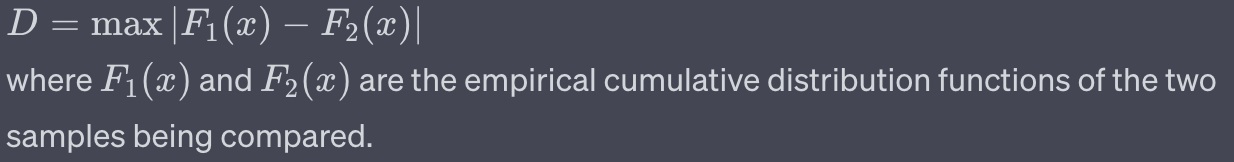

In [34]:
import plotly.graph_objects as go

# Create ECDF traces for Train Data and New Data
train_trace = go.Figure(data=[
    go.Scatter(
        x=np.sort(X_train.flatten()),  # Assuming X_train is a single-feature numpy array
        y=np.linspace(0, 1, len(X_train.flatten()), endpoint=False),
        line=dict(color='blue', width=2),
        # fill='tozeroy',
        name='Train Data'
    )
])

new_data_trace = go.Figure(data=[
    go.Scatter(
        x=np.sort(new_data.flatten()),  # Assuming new_data is a single-feature numpy array
        y=np.linspace(0, 1, len(new_data.flatten()), endpoint=False),
        line=dict(color='red', width=2),
        # fill='tozeroy',
        name='New Data'
    )
])

# Combine the traces into a single figure
fig = go.Figure(data=[train_trace.data[0], new_data_trace.data[0]])

# Customize the layout
fig.update_layout(
    title="ECDF of Train Data and New Data",
    xaxis_title="Value",
    yaxis_title="Cumulative Probability",
    legend_title="Data Source",
    template='plotly_white'
)

# Display the figure
fig.show()


In [7]:
from scipy.stats import ks_2samp

def ks_test(reference_data, new_data):
    for feature_index in range(reference_data.shape[1]):
        stat, p_value = ks_2samp(reference_data[:, feature_index], new_data[:, feature_index])
        if p_value < 0.05:  # A threshold for significance
            print(f'Data drift detected in feature {feature_index}: p-value {p_value:.3f}')

# Apply KS Test
ks_test(X_train, new_data)

Data drift detected in feature 0: p-value 0.000
Data drift detected in feature 1: p-value 0.000
Data drift detected in feature 2: p-value 0.000
Data drift detected in feature 3: p-value 0.000
Data drift detected in feature 4: p-value 0.000
Data drift detected in feature 5: p-value 0.000
Data drift detected in feature 6: p-value 0.000
Data drift detected in feature 7: p-value 0.000
Data drift detected in feature 8: p-value 0.000
Data drift detected in feature 9: p-value 0.000
Data drift detected in feature 10: p-value 0.000
Data drift detected in feature 11: p-value 0.000
Data drift detected in feature 12: p-value 0.000
Data drift detected in feature 13: p-value 0.000
Data drift detected in feature 14: p-value 0.000
Data drift detected in feature 15: p-value 0.000
Data drift detected in feature 16: p-value 0.000
Data drift detected in feature 17: p-value 0.000
Data drift detected in feature 18: p-value 0.000
Data drift detected in feature 19: p-value 0.000


The Population Stability Index compares the distribution of a feature in a reference dataset and a new dataset using histograms. The PSI is calculated as:

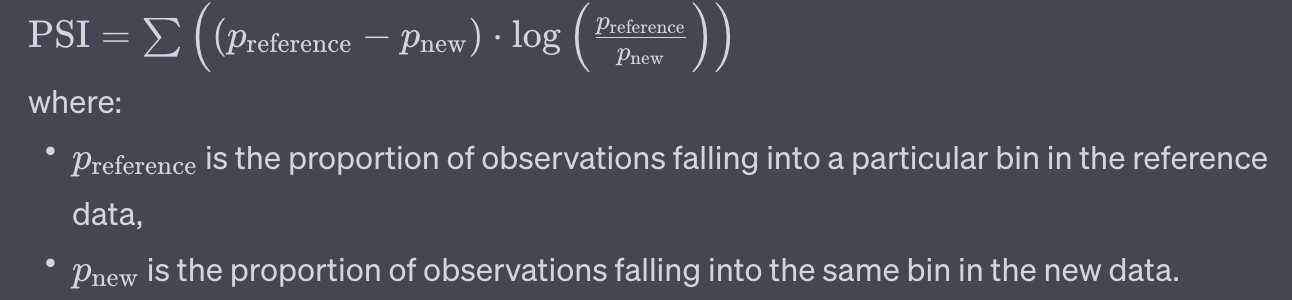

In [32]:
import plotly.figure_factory as ff
import pandas as pd
import numpy as np

# Assuming X_train and new_data are numpy arrays and have a single feature for simplicity.
# If they have more features, you might want to select one or loop through them.

# Convert the data to DataFrame for better handling with plotly
train_df = pd.DataFrame(X_train, columns=[f'Feature {i}' for i in range(X_train.shape[1])])
new_data_df = pd.DataFrame(new_data, columns=[f'Feature {i}' for i in range(new_data.shape[1])])

# Selecting a single feature for demonstration
feature = 'Feature 0'
# Create a distplot with custom bin_size
fig = ff.create_distplot([train_df[feature], new_data_df[feature]], 
                         group_labels=['Train Data', 'New Data'],
                         bin_size=.2, colors=['blue', 'red'])

fig.show()


In [15]:
def population_stability_index(reference_data, new_data, num_bins=10):
    for feature_index in range(reference_data.shape[1]):
        reference_hist, _ = np.histogram(reference_data[:, feature_index], bins=num_bins)
        new_hist, _ = np.histogram(new_data[:, feature_index], bins=num_bins)

        reference_ratios = reference_hist / sum(reference_hist)
        new_ratios = new_hist / sum(new_hist)

        psi = np.sum((reference_ratios - new_ratios) * np.log(reference_ratios / new_ratios))
        if psi > 0.1:  # A threshold for PSI
            print(f'Data drift detected in feature {feature_index}: PSI {psi:.3f}')

# Apply PSI
population_stability_index(X_train, new_data)


Data drift detected in feature 0: PSI 0.243
Data drift detected in feature 1: PSI 0.143
Data drift detected in feature 2: PSI 0.184
Data drift detected in feature 3: PSI 0.777
Data drift detected in feature 5: PSI 0.228
Data drift detected in feature 6: PSI 0.316
Data drift detected in feature 7: PSI 0.282
Data drift detected in feature 9: PSI 0.149
Data drift detected in feature 10: PSI 0.628
Data drift detected in feature 11: PSI 0.358
Data drift detected in feature 12: PSI 0.212
Data drift detected in feature 13: PSI 0.164
Data drift detected in feature 15: PSI 0.166
Data drift detected in feature 18: PSI 0.232
